# Merge three csv files 

In [1]:
import pandas as pd
import os 

In [2]:
root = 'merging_labels/'
fnames = os.listdir(root)
fulls = [os.path.join(root,i) for i in fnames]
fields = ['image', 'choice']
merge_data = pd.concat([pd.read_csv(f, skipinitialspace=True, usecols=fields) for f in fulls])

In [3]:
merge_data

,image,choice
0,GX010049_frame10350,Very safe
1,GX010049_frame10800,Very safe
2,GX010049_frame11100,Very safe
3,GX010049_frame11700,Very safe
4,GX010049_frame11850,Very safe
...,...,...
994,/data/local-files/?d=Users/admin/environments/...,NaN
995,/data/local-files/?d=Users/admin/environments/...,Safe
996,/data/local-files/?d=Users/admin/environments/...,Safe
997,/data/local-files/?d=Users/admin/environments/...,Very safe


In [4]:
df = merge_data
df['image'] = df['image'].apply(lambda x: x.split('/')[-1] if x[0]=='/' else x+'.jpg')#only get fname instead of whole path

# calculate certainty score for each image
Save image fname with certainty score > 0.5 to training_img_list

In [5]:
import numpy as np
def certainty_score(score_list):
    arr = np.array(score_list)
    unique_values, counts = np.unique(arr, return_counts=True)
    index_max = np.argmax(counts)
    return unique_values[index_max], counts[index_max]/len(score_list)

In [6]:
unique_image_list = pd.unique(df['image']).tolist()

In [7]:
merge_score_list = []
gt_label_list = []
training_img_list = []
certainty_thres = 0.5
for img in unique_image_list:
    rows = df.loc[df['image'] == img]
    score_list = rows['choice'].tolist()
    if len(score_list)==3:
        label = certainty_score(score_list)[0]
        final_score = float(certainty_score(score_list)[-1])
        merge_score_list.append(final_score) #check certainty score for all images (not filter out pics with low certainty score)
        if final_score>certainty_thres: #only save images if they have certainty score>0.5    
            gt_label_list.append(label)
            training_img_list.append(img)

# Show certainty score boxplot

{'whiskers': [<matplotlib.lines.Line2D at 0x11956caa0>,
 'caps': [<matplotlib.lines.Line2D at 0x11956d0d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x11956c8c0>],
 'medians': [<matplotlib.lines.Line2D at 0x11956d700>],
 'fliers': [<matplotlib.lines.Line2D at 0x11956da00>],
 'means': []}

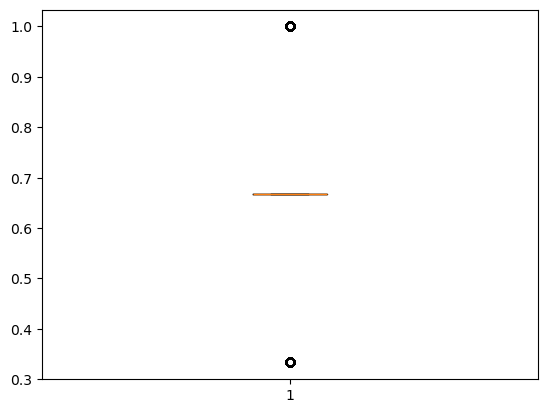

In [8]:
import matplotlib.pyplot as plt
plt.boxplot(merge_score_list)

In [9]:
len(training_img_list), len(gt_label_list)

(748, 748)

## check how disagree in merge_score_list

In [10]:
totally_agree = 0
mostly_agree = 0
disagree = 0
for s in merge_score_list:
    if s==1:
        totally_agree+=1
    elif s>0.5 and s<0.7:
        mostly_agree+=1
    else:
        disagree+=1
print(totally_agree/len(merge_score_list), mostly_agree/len(merge_score_list), disagree/len(merge_score_list))

0.23581757508342602 0.5962180200222469 0.16796440489432704


# Save training data
* 'gt_df.csv': four labels
* 'gt_df_simple.csv': two labels

In [11]:
data = {'image': training_img_list,
        'label': gt_label_list}
gt_df = pd.DataFrame(data)
gt_df.to_csv('gt_df.csv', index=False)

In [12]:
gt_df.head(-5)

,image,label
0,GX010049_frame10350.jpg,Safe
1,GX010049_frame10800.jpg,Safe
2,GX010049_frame12750.jpg,Safe
3,GX010049_frame13500.jpg,Safe
4,GX010049_frame14250.jpg,Very safe
...,...,...
738,GX080055_frame19650.jpg,Safe
739,GX080055_frame2550.jpg,Unsafe
740,GX080055_frame300.jpg,Safe
741,GX080055_frame3300.jpg,Unsafe


In [13]:
# simplify gt_df
for i in range(len(gt_df)):
    l = gt_df['label'].loc[i]
    if l == 'Very safe':
        gt_df['label'].loc[i]='Safe'
    elif l == 'Very unsafe':
        gt_df['label'].loc[i]='Unsafe'
    else:
        continue

In [14]:
gt_df.to_csv('gt_df_simple.csv', index=False)